In [219]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import time

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

from sklearn.kernel_approximation import RBFSampler
from sklearn.preprocessing import PolynomialFeatures

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multiclass import OneVsOneClassifier

from sklearn.model_selection import GridSearchCV

verbose_print = True

def log(*args, **kwargs):
    if verbose_print:
        print("LOG:", *args, **kwargs)

np.random.seed(42)

In [216]:
def load_csv(path):
    full = os.path.join('diabetes', path)
    return pd.read_csv(full)

df_immutable = load_csv('fav_ds.csv')


def features_response(df):
    return df.drop('readmitted', axis=1), df['readmitted']

def fresh_copy():
    return df_immutable.copy()

def fresh_dfs():
    return features_response(fresh_copy())
    
pd.set_option('display.max_columns', None)

print(df_immutable.info())
df_immutable.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7831 entries, 0 to 7830
Columns: 170 entries, age to readmitted
dtypes: float64(1), int64(168), object(1)
memory usage: 10.2+ MB
None


,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,weight_present,admission_type_id_2,admission_type_id_3,admission_type_id_4,admission_type_id_5,admission_type_id_6,admission_type_id_8,discharge_disposition_id_2,discharge_disposition_id_3,discharge_disposition_id_4,discharge_disposition_id_5,discharge_disposition_id_6,discharge_disposition_id_7,discharge_disposition_id_8,discharge_disposition_id_9,discharge_disposition_id_10,discharge_disposition_id_12,discharge_disposition_id_18,discharge_disposition_id_22,discharge_disposition_id_25,admission_source_id_2,admission_source_id_3,admission_source_id_4,admission_source_id_5,admission_source_id_6,admission_source_id_7,admission_source_id_8,admission_source_id_9,admission_source_id_17,admission_source_id_20,race_Asian,race_Caucasian,race_Hispanic,race_Other,race_bamboozled,gender_Male,medical_specialty_Emergency/Trauma,medical_specialty_Endocrinology,medical_specialty_Family/GeneralPractice,medical_specialty_Gastroenterology,medical_specialty_Gynecology,medical_specialty_Hematology/Oncology,medical_specialty_InternalMedicine,medical_specialty_Nephrology,medical_specialty_Neurology,medical_specialty_Obsterics&Gynecology-GynecologicOnco,medical_specialty_ObstetricsandGynecology,medical_specialty_Oncology,medical_specialty_Orthopedics,medical_specialty_Orthopedics-Reconstructive,medical_specialty_Otolaryngology,medical_specialty_Pediatrics,medical_specialty_Pediatrics-CriticalCare,medical_specialty_Pediatrics-Endocrinology,medical_specialty_PhysicalMedicineandRehabilitation,medical_specialty_Psychiatry,medical_specialty_Psychiatry-Child/Adolescent,medical_specialty_Psychology,medical_specialty_Pulmonology,medical_specialty_Radiology,medical_specialty_Surgery-Cardiovascular/Thoracic,medical_specialty_Surgery-General,medical_specialty_Surgery-Neuro,medical_specialty_Surgery-Thoracic,medical_specialty_Urology,medical_specialty_bamboozled,diag_1_Congenital Anomalies,diag_1_Diseases of the Blood and Blood-forming Organs,diag_1_Diseases of the Circulatory System,diag_1_Diseases of the Digestive System,diag_1_Diseases of the Genitourinary System,diag_1_Diseases of the Musculoskeletal System and Connective Tissue,diag_1_Diseases of the Nervous System and Sense Organs,diag_1_Diseases of the Respiratory System,diag_1_Diseases of the Skin and Subcutaneous Tissue,"diag_1_Endocrine, Nutritional and Metabolic Diseases, and Immunity Disorders",diag_1_Infectious and Parasitic Diseases,diag_1_Injury and Poisoning,diag_1_Mental Disorders,diag_1_Neoplasms,diag_1_None,diag_1_Supplementary Classification of Factors influencing Health Status and Contact with Health Services,"diag_1_Symptoms, Signs and Ill-defined Conditions",diag_2_Congenital Anomalies,diag_2_Diseases of the Blood and Blood-forming Organs,diag_2_Diseases of the Circulatory System,diag_2_Diseases of the Digestive System,diag_2_Diseases of the Genitourinary System,diag_2_Diseases of the Musculoskeletal System and Connective Tissue,diag_2_Diseases of the Nervous System and Sense Organs,diag_2_Diseases of the Respiratory System,diag_2_Diseases of the Skin and Subcutaneous Tissue,"diag_2_Endocrine, Nutritional and Metabolic Diseases, and Immunity Disorders",diag_2_Infectious and Parasitic Diseases,diag_2_Injury and Poisoning,diag_2_Mental Disorders,diag_2_Neoplasms,diag_2_None,diag_2_Supplementary Classification of Factors influencing Health Status and Contact with Health Services,"diag_2_Symptoms, Signs and Ill-defined Conditions",diag_2_injury and poisoning,diag_3_Congenital Anomalies,diag_3_Diseases of the Blood and Blood-forming Organs,diag_3_Diseases of the Circulatory System,diag_3_Diseases of the Digestive System,diag_3_Diseases of the Genitourinary System,diag_3_Diseases of the Musculoskeletal System and Connective Tissue,diag_3_Diseases of the Nervous System and Sense Organs,diag_3_Diseases of the Respiratory System,diag_3_Diseases of the Skin an

In [240]:
def process_df(df, labels):
    # Split into train and test
    
    X_all, y_all = df.values, labels.values
    feature_names = df.columns

    X_all = StandardScaler().fit_transform(X_all)

    sss = StratifiedShuffleSplit(n_splits=1, random_state=42)
    train_full_idx, test_idx = next(sss.split(X_all, y_all))

    X_train_full, y_train_full = X_all[train_full_idx], y_all[train_full_idx]
    X_test, y_test = X_all[test_idx], y_all[test_idx]

    # Further split train into train and validation
    sss = StratifiedShuffleSplit(n_splits=1, random_state=42, test_size=0.2)

    train_idx, dev_idx = next(sss.split(X_train_full, y_train_full))
    X_train, y_train = X_train_full[train_idx], y_train_full[train_idx]
    X_dev, y_dev = X_train_full[dev_idx], y_train_full[dev_idx]

    log(f"Shape of train: {X_train.shape}, {y_train.shape}")
    log(f"Shape of dev: {X_dev.shape}, {y_train.shape}")
    log(f"Shape of test: {X_test.shape}, {y_test.shape}")
    
    return X_train, y_train, X_dev, y_dev, X_test, y_test

def fresh_sets():
    df, labels = fresh_dfs()
    return process_df(df, labels)

def self_acc(model, X, y):
    log("Calculating accuracy on the test data...")
    model.fit(X, y)
    pred = model.predict(X)
    
    acc = accuracy_score(y, pred)
    
    log(f"Accuracy on the test data is {acc}")

def cv_acc(model, cv=5):
    
    X_train, y_train, X_dev, y_dev, X_test, y_test = fresh_sets()
    
    full_X = np.concatenate((X_train, X_test))
    full_y = np.concatenate((y_train, y_test))
    
    log(f"Model {model}")
    
    self_acc(model, full_X, full_y)
    
    start = time.time()
    acc = np.mean(cross_val_score(model, full_X, full_y, cv=cv))
    log(f"Cross val score: {acc}")
    
    elapsed = time.time() - start
    log(f"Mean elapsed for each cv: {elapsed/cv}\n")
    
    return acc

## Logistic Regression

In [207]:
logreg_base = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=10)
cv_acc(logreg_base, cv=10)

LOG: Shape of train: (5637, 169), (5637,)
LOG: Shape of dev: (1410, 169), (5637,)
LOG: Shape of test: (784, 169), (784,)
LOG: Model LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
LOG: Calculating accuracy on the test data...
LOG: Accuracy on the test data is 0.5464880859679178


/home/simeon/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/simeon/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/simeon/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/simeon/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/simeon/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

LOG: Cross val score: 0.5106839748135696

LOG: Mean elapsed for each cv: 0.09905385971069336


/home/simeon/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/simeon/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


0.5106839748135696

In [199]:
params = {
    'solver': ['saga', 'lbfgs', 'newton-cg'],
#     'class_weight': [
#         None,
#         {'NO': 0.25, '<30': 0.5, '>30': 0.25},
#         {'NO': 0.5, '<30': 0.25, '>30': 0.25},
#         {'NO': 0.25, '<30': 0.25, '>30': 0.5}
#     ],
    'max_iter': [150],
    'multi_class': ['ovr', 'multinomial']
}

X_train, y_train, X_dev, y_dev, X_test, y_test = fresh_sets()
X_all = np.concatenate((X_train, X_dev))
y_all = np.concatenate((y_train, y_dev))

grid_logreg = GridSearchCV(LogisticRegression(), params, cv=10)
grid_logreg.fit(X_all, y_all)
grid_logreg.cv_results_

LOG: Shape of train: (5637, 169), (5637,)
LOG: Shape of dev: (1410, 169), (5637,)
LOG: Shape of test: (784, 169), (784,)


/home/simeon/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/simeon/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/simeon/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/simeon/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/simeon/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was

{'mean_fit_time': array([5.76218112, 0.66307034, 1.51528952, 3.11108055, 0.84492071,
        0.94140925]),
 'std_fit_time': array([0.64406484, 0.17555871, 0.37397487, 0.17639572, 0.32229421,
        0.12867468]),
 'mean_score_time': array([0.0011328 , 0.00171418, 0.0010268 , 0.00149705, 0.00136917,
        0.00103061]),
 'std_score_time': array([1.51905308e-04, 2.09577534e-03, 1.48226769e-05, 9.15808755e-04,
        8.05199579e-04, 2.14807201e-05]),
 'param_max_iter': masked_array(data=[150, 150, 150, 150, 150, 150],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_multi_class': masked_array(data=['ovr', 'ovr', 'ovr', 'multinomial', 'multinomial',
                    'multinomial'],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_solver': masked_array(data=['saga', 'lbfgs', 'newton-cg', 'saga', 'lbfgs',
                    'newton-cg'],
  

In [200]:
grid_logreg.best_params_

{'max_iter': 150, 'multi_class': 'multinomial', 'solver': 'saga'}

In [208]:
logreg_best = grid_logreg.best_estimator_
cv_acc(logreg_best, cv=10)

LOG: Shape of train: (5637, 169), (5637,)
LOG: Shape of dev: (1410, 169), (5637,)
LOG: Shape of test: (784, 169), (784,)
LOG: Model LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=150,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)
LOG: Calculating accuracy on the test data...


/home/simeon/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LOG: Accuracy on the test data is 0.5455536520791154


/home/simeon/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/simeon/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/simeon/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/simeon/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/simeon/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was

LOG: Cross val score: 0.5103719623330704

LOG: Mean elapsed for each cv: 3.005100893974304


/home/simeon/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.5103719623330704

In [311]:
logreg_fav = logreg_best

In [196]:
pd.DataFrame(grid_logreg.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_multi_class,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,3.402091,0.158524,0.001184,0.000381,ovr,saga,"{'multi_class': 'ovr', 'solver': 'saga'}",0.510638,0.516312,0.499291,0.470922,0.513475,0.496454,0.523404,0.527660,0.481534,0.529161,0.506882,0.018571,4
1,0.585539,0.139482,0.001279,0.000916,ovr,lbfgs,"{'multi_class': 'ovr', 'solver': 'lbfgs'}",0.510638,0.516312,0.495035,0.468085,0.512057,0.502128,0.521986,0.521986,0.487216,0.523471,0.505889,0.017048,5
2,1.311466,0.211320,0.001023,0.000021,ovr,newton-cg,"{'multi_class': 'ovr', 'solver': 'newton-cg'}",0.510638,0.516312,0.495035,0.468085,0.512057,0.502128,0.521986,0.521986,0.485795,0.523471,0.505747,0.017208,6
3,1.980100,0.005678,0.001129,0.000083,multinomial,saga,"{'multi_class': 'multinomial', 'solver': 'saga'}",0.503546,0.504965,0.506383,0.473759,0.517730,0.507801,0.524823,0.526241,0.488636,0.530583,0.508443,0.016724,1
4,0.311517,0.008646,0.000944,0.000013,multinomial,lbfgs,"{'multi_class': 'multinomial', 'solver': 'lbfgs'}",0.509220,0.507801,0.502128,0.475177,0.513475,0.503546,0.526241,0.521986,0.485795,0.524893,0.507024,0.015684,2
5,0.857382,0.046573,0.000927,0.000017,multinomial,newton-cg,"{'multi_class': 'multinomial', 'solver': 'newt...",0.509220,0.507801,0.502128,0.473759,0.514894,0.502128,0.526241,0.521986,0.487216,0.524893,0.507024,0.015894,2


In [179]:
scores = [(val, cv_acc(LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=val), cv=10))
          for val in np.linspace(10, 200, 10)]
scores = np.array(scores)
scores

LOG: Shape of train: (5637, 169), (5637,)
LOG: Shape of dev: (1410, 169), (5637,)
LOG: Shape of test: (784, 169), (784,)
LOG: Model LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10.0,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


/home/simeon/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/simeon/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/simeon/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/simeon/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/simeon/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

LOG: Cross val score: 0.5106839748135696

LOG: Mean elapsed for each cv: 0.0764693260192871
LOG: Shape of train: (5637, 169), (5637,)
LOG: Shape of dev: (1410, 169), (5637,)
LOG: Shape of test: (784, 169), (784,)
LOG: Model LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None,
                   max_iter=31.11111111111111, multi_class='multinomial',
                   n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
                   tol=0.0001, verbose=0, warm_start=False)


/home/simeon/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/simeon/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/simeon/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/simeon/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/simeon/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

LOG: Cross val score: 0.5102162013571736

LOG: Mean elapsed for each cv: 0.18667585849761964
LOG: Shape of train: (5637, 169), (5637,)
LOG: Shape of dev: (1410, 169), (5637,)
LOG: Shape of test: (784, 169), (784,)
LOG: Model LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None,
                   max_iter=52.22222222222222, multi_class='multinomial',
                   n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
                   tol=0.0001, verbose=0, warm_start=False)


/home/simeon/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/simeon/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/simeon/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/simeon/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/simeon/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

LOG: Cross val score: 0.5097479373720719

LOG: Mean elapsed for each cv: 0.288230299949646
LOG: Shape of train: (5637, 169), (5637,)
LOG: Shape of dev: (1410, 169), (5637,)
LOG: Shape of test: (784, 169), (784,)
LOG: Model LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None,
                   max_iter=73.33333333333333, multi_class='multinomial',
                   n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
                   tol=0.0001, verbose=0, warm_start=False)


/home/simeon/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/simeon/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/simeon/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/simeon/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/simeon/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

LOG: Cross val score: 0.5099032168751776

LOG: Mean elapsed for each cv: 0.24488189220428466
LOG: Shape of train: (5637, 169), (5637,)
LOG: Shape of dev: (1410, 169), (5637,)
LOG: Shape of test: (784, 169), (784,)
LOG: Model LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None,
                   max_iter=94.44444444444444, multi_class='multinomial',
                   n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
                   tol=0.0001, verbose=0, warm_start=False)


/home/simeon/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/simeon/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/simeon/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/simeon/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/simeon/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

LOG: Cross val score: 0.5097481803724462

LOG: Mean elapsed for each cv: 0.32572212219238283
LOG: Shape of train: (5637, 169), (5637,)
LOG: Shape of dev: (1410, 169), (5637,)
LOG: Shape of test: (784, 169), (784,)
LOG: Model LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None,
                   max_iter=115.55555555555556, multi_class='multinomial',
                   n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
                   tol=0.0001, verbose=0, warm_start=False)


/home/simeon/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/simeon/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/simeon/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/simeon/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/simeon/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

LOG: Cross val score: 0.5102152293556768

LOG: Mean elapsed for each cv: 0.3529199123382568
LOG: Shape of train: (5637, 169), (5637,)
LOG: Shape of dev: (1410, 169), (5637,)
LOG: Shape of test: (784, 169), (784,)
LOG: Model LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None,
                   max_iter=136.66666666666666, multi_class='multinomial',
                   n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
                   tol=0.0001, verbose=0, warm_start=False)


/home/simeon/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/simeon/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/simeon/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/simeon/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/simeon/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

LOG: Cross val score: 0.5102152293556768

LOG: Mean elapsed for each cv: 0.40077862739562986
LOG: Shape of train: (5637, 169), (5637,)
LOG: Shape of dev: (1410, 169), (5637,)
LOG: Shape of test: (784, 169), (784,)
LOG: Model LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None,
                   max_iter=157.77777777777777, multi_class='multinomial',
                   n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
                   tol=0.0001, verbose=0, warm_start=False)


/home/simeon/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/simeon/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/simeon/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


LOG: Cross val score: 0.5100592231154272

LOG: Mean elapsed for each cv: 0.4340327024459839
LOG: Shape of train: (5637, 169), (5637,)
LOG: Shape of dev: (1410, 169), (5637,)
LOG: Shape of test: (784, 169), (784,)
LOG: Model LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None,
                   max_iter=178.88888888888889, multi_class='multinomial',
                   n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
                   tol=0.0001, verbose=0, warm_start=False)
LOG: Cross val score: 0.5100592231154272

LOG: Mean elapsed for each cv: 0.4295438528060913
LOG: Shape of train: (5637, 169), (5637,)
LOG: Shape of dev: (1410, 169), (5637,)
LOG: Shape of test: (784, 169), (784,)
LOG: Model LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=200.0,
                   multi_class='multinomial', n_jobs=Non

array([[ 10.        ,   0.51068397],
       [ 31.11111111,   0.5102162 ],
       [ 52.22222222,   0.50974794],
       [ 73.33333333,   0.50990322],
       [ 94.44444444,   0.50974818],
       [115.55555556,   0.51021523],
       [136.66666667,   0.51021523],
       [157.77777778,   0.51005922],
       [178.88888889,   0.51005922],
       [200.        ,   0.51005922]])

In [174]:

scores[:, 0]

array([ 10.        ,  31.11111111,  52.22222222,  73.33333333,
        94.44444444, 115.55555556, 136.66666667, 157.77777778,
       178.88888889, 200.        ])

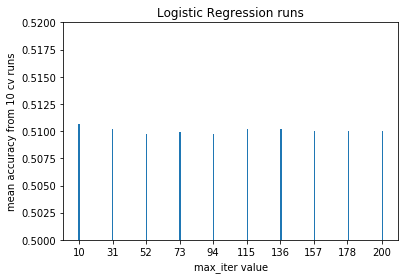

In [188]:
plt.ylim(bottom=0.5, top=0.52)
plt.xticks(scores[:, 0].astype(int))

plt.xlabel('max_iter value')
plt.ylabel('mean accuracy from 10 cv runs')
plt.title('Logistic Regression runs')

plt.bar(scores[:, 0], scores[:, 1])
plt.savefig('logreg_mi.png')

In [222]:
logreg_ovo = OneVsOneClassifier(LogisticRegression(solver='saga'))
cv_acc(logreg_ovo)

LOG: Shape of train: (5637, 169), (5637,)
LOG: Shape of dev: (1410, 169), (5637,)
LOG: Shape of test: (784, 169), (784,)
LOG: Model OneVsOneClassifier(estimator=LogisticRegression(C=1.0, class_weight=None,
                                                dual=False, fit_intercept=True,
                                                intercept_scaling=1,
                                                l1_ratio=None, max_iter=100,
                                                multi_class='warn', n_jobs=None,
                                                penalty='l2', random_state=None,
                                                solver='saga', tol=0.0001,
                                                verbose=0, warm_start=False),
                   n_jobs=None)
LOG: Calculating accuracy on the test data...


/home/simeon/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/simeon/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/simeon/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LOG: Accuracy on the test data is 0.5500700825416602


/home/simeon/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/simeon/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/simeon/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/simeon/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/simeon/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was

LOG: Cross val score: 0.5086548706678675

LOG: Mean elapsed for each cv: 2.122575283050537


/home/simeon/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.5086548706678675

In [209]:
logreg_poly = Pipeline([
    ('poly', PolynomialFeatures(degree=2)),
    ('logreg_base', logreg_base)
])
cv_acc(logreg_poly)

LOG: Shape of train: (5637, 169), (5637,)
LOG: Shape of dev: (1410, 169), (5637,)
LOG: Shape of test: (784, 169), (784,)
LOG: Model Pipeline(memory=None,
         steps=[('poly',
                 PolynomialFeatures(degree=2, include_bias=True,
                                    interaction_only=False, order='C')),
                ('logreg_base',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=10,
                                    multi_class='multinomial', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)
LOG: Calculating accuracy on the test data...


/home/simeon/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


LOG: Accuracy on the test data is 0.7042516741940508


/home/simeon/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/simeon/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/simeon/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/simeon/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/simeon/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

LOG: Cross val score: 0.48825034637665177

LOG: Mean elapsed for each cv: 3.1739120483398438


0.48825034637665177

In [52]:
logreg_rbf = Pipeline([('rbf', RBFSampler(random_state=42)), 
                      ('logreg_base', logreg_base)])
cv_acc(logreg_rbf)

LOG: Shape of train: (5637, 169), (5637,)
LOG: Shape of dev: (1410, 169), (5637,)
LOG: Shape of test: (784, 169), (784,)
LOG: Model Pipeline(memory=None,
         steps=[('rbf',
                 RBFSampler(gamma=1.0, n_components=100, random_state=42)),
                ('logreg_base',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)
LOG: Cross val score: 0.34636271181098927

LOG: Mean elapsed for each cv: 0.09910287857055664


In [110]:
from sklearn.linear_model import Perceptron
prec_base = Perceptron()
cv_acc(prec_base)

LOG: Shape of train: (5637, 169), (5637,)
LOG: Shape of dev: (1410, 169), (5637,)
LOG: Shape of test: (784, 169), (784,)
LOG: Model Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
           fit_intercept=True, max_iter=1000, n_iter_no_change=5, n_jobs=None,
           penalty=None, random_state=0, shuffle=True, tol=0.001,
           validation_fraction=0.1, verbose=0, warm_start=False)
LOG: Cross val score: 0.4508696690421095

LOG: Mean elapsed for each cv: 0.08219375610351562


## SGD

In [56]:
sgd_default = SGDClassifier(random_state=42)
cv_acc(sgd_default)

LOG: Shape of train: (5637, 169), (5637,)
LOG: Shape of dev: (1410, 169), (5637,)
LOG: Shape of test: (784, 169), (784,)
LOG: Model SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)
LOG: Cross val score: 0.4499339975199068

LOG: Mean elapsed for each cv: 0.6832798957824707


In [58]:
sgd_perceptron1 = SGDClassifier(random_state=42, loss='perceptron')
cv_acc(sgd_perceptron1)

LOG: Shape of train: (5637, 169), (5637,)
LOG: Shape of dev: (1410, 169), (5637,)
LOG: Shape of test: (784, 169), (784,)
LOG: Model SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='perceptron',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)
LOG: Cross val score: 0.44821453897055524

LOG: Mean elapsed for each cv: 0.7609124660491944


In [61]:
sgd_perceptron2 = SGDClassifier(random_state=42, loss="perceptron", eta0=1, learning_rate="constant", penalty=None)
cv_acc(sgd_perceptron2)

LOG: Shape of train: (5637, 169), (5637,)
LOG: Shape of dev: (1410, 169), (5637,)
LOG: Shape of test: (784, 169), (784,)
LOG: Model SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=1, fit_intercept=True,
              l1_ratio=0.15, learning_rate='constant', loss='perceptron',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty=None,
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)
LOG: Cross val score: 0.44136543312536586

LOG: Mean elapsed for each cv: 0.07721543312072754


In [62]:
sgd_rbf = Pipeline([('rbf', RBFSampler(random_state=42)), 
                  ('sgd_rbf', sgd_default)])
cv_acc(sgd_rbf)

LOG: Shape of train: (5637, 169), (5637,)
LOG: Shape of dev: (1410, 169), (5637,)
LOG: Shape of test: (784, 169), (784,)
LOG: Model Pipeline(memory=None,
         steps=[('rbf',
                 RBFSampler(gamma=1.0, n_components=100, random_state=42)),
                ('sgd_rbf',
                 SGDClassifier(alpha=0.0001, average=False, class_weight=None,
                               early_stopping=False, epsilon=0.1, eta0=0.0,
                               fit_intercept=True, l1_ratio=0.15,
                               learning_rate='optimal', loss='hinge',
                               max_iter=1000, n_iter_no_change=5, n_jobs=None,
                               penalty='l2', power_t=0.5, random_state=42,
                               shuffle=True, tol=0.001, validation_fraction=0.1,
                               verbose=0, warm_start=False))],
         verbose=False)
LOG: Cross val score: 0.3479251947648942

LOG: Mean elapsed for each cv: 0.28694887161254884


## SVC (SVM stuff)

In [131]:
params = {
    'kernel': ['poly', 'rbf', 'sigmoid'],
    'degree': [1, 2],
    'shrinking': [True, False]
}

X_train, y_train, X_dev, y_dev, X_test, y_test = fresh_sets()

grid_svc = grid_svcSearchCV(SVC(), params)
grid_svc.fit(X_train, y_train)
grid_svc.cv_results_

LOG: Shape of train: (5637, 169), (5637,)
LOG: Shape of dev: (1410, 169), (5637,)
LOG: Shape of test: (784, 169), (784,)


/home/simeon/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/home/simeon/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/simeon/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/simeon/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value 

/home/simeon/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/simeon/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/simeon/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/simeon/anaconda3/lib/python3.7/site-packages/skle

{'mean_fit_time': array([2.76453869, 3.14570014, 4.52066716, 4.0406483 , 4.64195275,
        3.27420823, 3.1869487 , 3.14888144, 3.59880813, 3.55464625,
        3.26803199, 3.51008908]),
 'std_fit_time': array([0.03847044, 0.52299492, 0.70552617, 0.46232629, 0.77488719,
        0.03475104, 0.00771693, 0.01049003, 0.02729364, 0.03409207,
        0.03484163, 0.18029028]),
 'mean_score_time': array([1.02957749, 1.10207009, 1.4294006 , 1.50439008, 1.87279836,
        1.25612823, 1.1724174 , 1.1626846 , 1.33969728, 1.33643826,
        1.27216005, 1.342043  ]),
 'std_score_time': array([0.00653938, 0.10183198, 0.15554823, 0.20095574, 0.54453187,
        0.00748993, 0.01197854, 0.00386984, 0.00958583, 0.00952867,
        0.0594668 , 0.12811689]),
 'param_degree': masked_array(data=[1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, False, False],
        fill_value='?',
             dtype=object),


In [223]:
svc_best = grid_svc.best_estimator_
cv_acc(svc_best, cv=10)

LOG: Shape of train: (5637, 169), (5637,)
LOG: Shape of dev: (1410, 169), (5637,)
LOG: Shape of test: (784, 169), (784,)
LOG: Model SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=1, gamma='auto_deprecated',
    kernel='poly', max_iter=-1, probability=False, random_state=None,
    shrinking=False, tol=0.001, verbose=False)
LOG: Calculating accuracy on the test data...


/home/simeon/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


LOG: Accuracy on the test data is 0.5432175673571095


/home/simeon/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/simeon/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/simeon/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/simeon/anaconda3/lib/python3.7/site-packages/skle

LOG: Cross val score: 0.5117721621850304

LOG: Mean elapsed for each cv: 8.697561335563659


0.5117721621850304

In [138]:
print(grid_svc.best_params_)
pd.DataFrame(grid_svc.cv_results_)

{'degree': 1, 'kernel': 'poly', 'shrinking': False}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_degree,param_kernel,param_shrinking,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,2.764539,0.038470,1.029577,0.006539,1,poly,True,"{'degree': 1, 'kernel': 'poly', 'shrinking': T...",0.517553,0.483511,0.517848,0.506298,0.016120,2
1,3.145700,0.522995,1.102070,0.101832,1,poly,False,"{'degree': 1, 'kernel': 'poly', 'shrinking': F...",0.518085,0.483511,0.517848,0.506475,0.016245,1
2,4.520667,0.705526,1.429401,0.155548,1,rbf,True,"{'degree': 1, 'kernel': 'rbf', 'shrinking': True}",0.511170,0.493617,0.505061,0.503282,0.007277,7
3,4.040648,0.462326,1.504390,0.200956,1,rbf,False,"{'degree': 1, 'kernel': 'rbf', 'shrinking': Fa...",0.511170,0.493617,0.505061,0.503282,0.007277,7
4,4.641953,0.774887,1.872798,0.544532,1,sigmoid,True,"{'degree': 1, 'kernel': 'sigmoid', 'shrinking'...",0.517021,0.481383,0.515717,0.504701,0.016504,3
5,3.274208,0.034751,1.256128,0.007490,1,sigmoid,False,"{'degree': 1, 'kernel': 'sigmoid', 'shrinking'...",0.514362,0.481915,0.516782,0.504346,0.015898,5
6,3.186949,0.007717,1.172417,0.011979,2,poly,True,"{'degree': 2, 'kernel': 'poly', 'shrinking': T...",0.486170,0.463830,0.490677,0.480220,0.011739,11
7,3.148881,0.010490,1.162685,0.003870,2,poly,False,"{'degree': 2, 'kernel': 'poly', 'shrinking': F...",0.486170,0.463830,0.490677,0.480220,0.011739,11
8,3.598808,0.027294,1.339697,0.009586,2,rbf,True,"{'degree': 2, 'kernel': 'rbf', 'shrinking': True}",0.511170,0.493617,0.505061,0.503282,0.007277,7
9,3.554646,0.034092,1.336438,0.009529,2,rbf,False,"{'degree': 2, 'kernel': 'rbf', 'shrinking': Fa...",0.511170,0.493617,0.505061,0.503282,0.007277,7


In [82]:
svm_probs = SVC(probability=True, random_state=42) # So that it estimates probability
cv_acc(svm_probs)

LOG: Shape of train: (5637, 169), (5637,)
LOG: Shape of dev: (1410, 169), (5637,)
LOG: Shape of test: (784, 169), (784,)
LOG: Model SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=True, random_state=42,
    shrinking=True, tol=0.001, verbose=False)


/home/simeon/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/simeon/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/simeon/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/simeon/anaconda3/lib/python3.7/site-packages/skle

LOG: Cross val score: 0.5088042096127248

LOG: Mean elapsed for each cv: 34.62553858757019


In [67]:
g_base = GaussianNB()
cv_acc(g_base)

LOG: Shape of train: (5637, 169), (5637,)
LOG: Shape of dev: (1410, 169), (5637,)
LOG: Shape of test: (784, 169), (784,)
LOG: Model GaussianNB(priors=None, var_smoothing=1e-09)
LOG: Cross val score: 0.3997976893677217

LOG: Mean elapsed for each cv: 0.03968515396118164


## Decision Trees

In [64]:
dt_base = DecisionTreeClassifier(random_state=42)
cv_acc(dt_base)

LOG: Shape of train: (5637, 169), (5637,)
LOG: Shape of dev: (1410, 169), (5637,)
LOG: Shape of test: (784, 169), (784,)
LOG: Model DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')
LOG: Cross val score: 0.44494314331811263

LOG: Mean elapsed for each cv: 0.11805148124694824


# Ensembles
## RandomForestClassifier

In [231]:
rf_base = RandomForestClassifier(n_estimators=20, n_jobs=3, random_state=42)
cv_acc(rf_base)

LOG: Shape of train: (5637, 169), (5637,)
LOG: Shape of dev: (1410, 169), (5637,)
LOG: Shape of test: (784, 169), (784,)
LOG: Model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=3,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
LOG: Calculating accuracy on the test data...
LOG: Accuracy on the test data is 0.9985983491667965
LOG: Cross val score: 0.4980674425342043

LOG: Mean elapsed for each cv: 0.31060452461242677


0.4980674425342043

In [ ]:
rf_play = RandomForestClassifier(n_estimators=200, n_jobs=3, random_state=42, max_leaf_nodes=1000)
cv_acc(rf_play)

In [245]:
rf_stats = [(int(mleafs), 
             cv_acc(RandomForestClassifier(n_estimators=200, n_jobs=3, random_state=42, max_leaf_nodes=int(mleafs))))
            for mleafs in np.linspace(10, 2500, 10)]
rf_stats = rf_stats = np.array(rf_stats)
rf_stats

LOG: Shape of train: (5637, 169), (5637,)
LOG: Shape of dev: (1410, 169), (5637,)
LOG: Shape of test: (784, 169), (784,)
LOG: Model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=10,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=3,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
LOG: Calculating accuracy on the test data...
LOG: Accuracy on the test data is 0.5145615947671702
LOG: Cross val score: 0.5056846984553359
LOG: Mean elapsed for each cv: 0.5006134510040283

LOG: Shape of train: (5637, 169), (5637,)
LOG: Shape of dev: (1410, 169), (5637,)
LOG: Shape of test: (784, 169), (784,)
LOG: Model RandomForestClassifier(bootstrap=True, class_weight=None, cri

[(10, 0.5056846984553359),
 (286, 0.5329452379422742),
 (563, 0.5301389506757224),
 (840, 0.5302933807209727),
 (1116, 0.5309158283523381),
 (1393, 0.5321614509151253),
 (1670, 0.531380936738229),
 (1946, 0.5321661783654901),
 (2223, 0.5318547727247933),
 (2500, 0.5318547727247933)]

In [246]:
rf_stats = np.array(rf_stats)
rf_stats

array([[1.00000000e+01, 5.05684698e-01],
       [2.86000000e+02, 5.32945238e-01],
       [5.63000000e+02, 5.30138951e-01],
       [8.40000000e+02, 5.30293381e-01],
       [1.11600000e+03, 5.30915828e-01],
       [1.39300000e+03, 5.32161451e-01],
       [1.67000000e+03, 5.31380937e-01],
       [1.94600000e+03, 5.32166178e-01],
       [2.22300000e+03, 5.31854773e-01],
       [2.50000000e+03, 5.31854773e-01]])

In [261]:
rf_stats[:, 0].astype(int)

array([  10,  286,  563,  840, 1116, 1393, 1670, 1946, 2223, 2500])

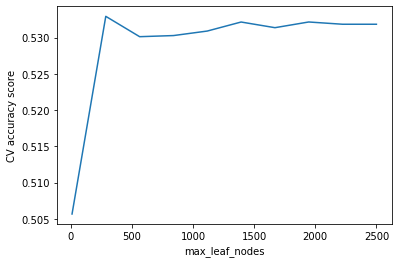

In [271]:
plt.plot(rf_stats[:, 0], rf_stats[:, 1])
plt.xlabel('max_leaf_nodes')
plt.ylabel('CV accuracy score')
# plt.xticks(rf_stats[:, 0])
plt.savefig('rf-param-mln.png')

In [268]:
rf_est_stats = [(int(nest), 
             cv_acc(RandomForestClassifier(n_estimators=int(nest), n_jobs=3, random_state=42, max_leaf_nodes=300)))
            for nest in np.linspace(10, 2500, 10)]
rf_est_stats = np.array(rf_est_stats)
rf_est_stats

LOG: Shape of train: (5637, 169), (5637,)
LOG: Shape of dev: (1410, 169), (5637,)
LOG: Shape of test: (784, 169), (784,)
LOG: Model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=300,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=3,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
LOG: Calculating accuracy on the test data...
LOG: Accuracy on the test data is 0.7165550537299487
LOG: Cross val score: 0.5061541706415635
LOG: Mean elapsed for each cv: 0.45767841339111326

LOG: Shape of train: (5637, 169), (5637,)
LOG: Shape of dev: (1410, 169), (5637,)
LOG: Shape of test: (784, 169), (784,)
LOG: Model RandomForestClassifier(bootstrap=True, class_weight=None, cr

array([[1.00000000e+01, 5.06154171e-01],
       [2.86000000e+02, 5.35123259e-01],
       [5.63000000e+02, 5.33877637e-01],
       [8.40000000e+02, 5.35593095e-01],
       [1.11600000e+03, 5.32788990e-01],
       [1.39300000e+03, 5.33880546e-01],
       [1.67000000e+03, 5.32944147e-01],
       [1.94600000e+03, 5.33256280e-01],
       [2.22300000e+03, 5.32166906e-01],
       [2.50000000e+03, 5.32009566e-01]])

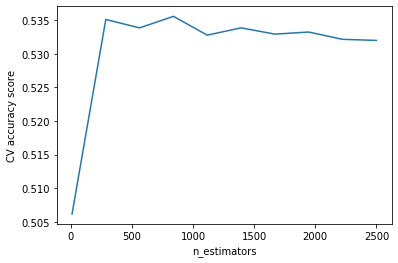

In [288]:
plt.plot(rf_est_stats[:, 0], rf_est_stats[:, 1])
plt.xlabel('n_estimators')
plt.ylabel('CV accuracy score')
# plt.xticks(rf_est_stats[:, 0])
plt.savefig('rf-param-nest.png')

In [274]:
rf_fav = RandomForestClassifier(random_state=42, n_estimators=300, max_leaf_nodes=300, n_jobs=3)
cv_acc(rf_fav)

LOG: Shape of train: (5637, 169), (5637,)
LOG: Shape of dev: (1410, 169), (5637,)
LOG: Shape of test: (784, 169), (784,)
LOG: Model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=300,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=3,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
LOG: Calculating accuracy on the test data...
LOG: Accuracy on the test data is 0.7737112599283601
LOG: Cross val score: 0.5355912767631268
LOG: Mean elapsed for each cv: 1.2400004386901855



0.5355912767631268

## ExtraTrees

In [227]:
et_base = ExtraTreesClassifier(random_state=42)
cv_acc(et_base)

LOG: Shape of train: (5637, 169), (5637,)
LOG: Shape of dev: (1410, 169), (5637,)
LOG: Shape of test: (784, 169), (784,)
LOG: Model ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                     max_depth=None, max_features='auto', max_leaf_nodes=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators='warn',
                     n_jobs=None, oob_score=False, random_state=42, verbose=0,
                     warm_start=False)
LOG: Calculating accuracy on the test data...
LOG: Accuracy on the test data is 1.0


/home/simeon/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


LOG: Cross val score: 0.48201314231201414

LOG: Mean elapsed for each cv: 0.12011451721191406


0.48201314231201414

In [228]:
et_play = ExtraTreesClassifier(random_state=42, n_estimators=300)
cv_acc(et_play)

LOG: Shape of train: (5637, 169), (5637,)
LOG: Shape of dev: (1410, 169), (5637,)
LOG: Shape of test: (784, 169), (784,)
LOG: Model ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                     max_depth=None, max_features='auto', max_leaf_nodes=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=300,
                     n_jobs=None, oob_score=False, random_state=42, verbose=0,
                     warm_start=False)
LOG: Calculating accuracy on the test data...
LOG: Accuracy on the test data is 1.0
LOG: Cross val score: 0.5243712187973124

LOG: Mean elapsed for each cv: 3.109996223449707


0.5243712187973124

In [278]:
et_fav = ExtraTreesClassifier(random_state=42, n_estimators=300, max_leaf_nodes=300, n_jobs=3)
cv_acc(et_fav)

LOG: Shape of train: (5637, 169), (5637,)
LOG: Shape of dev: (1410, 169), (5637,)
LOG: Shape of test: (784, 169), (784,)
LOG: Model ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                     max_depth=None, max_features='auto', max_leaf_nodes=300,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=3,
                     oob_score=False, random_state=42, verbose=0,
                     warm_start=False)
LOG: Calculating accuracy on the test data...
LOG: Accuracy on the test data is 0.7850802055754555
LOG: Cross val score: 0.531693796979038
LOG: Mean elapsed for each cv: 1.1569228649139405



0.531693796979038

## AdaBoost

In [281]:
ada_base = AdaBoostClassifier(n_estimators=50)
cv_acc(ada_base)

LOG: Shape of train: (5637, 169), (5637,)
LOG: Shape of dev: (1410, 169), (5637,)
LOG: Shape of test: (784, 169), (784,)
LOG: Model AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)
LOG: Calculating accuracy on the test data...
LOG: Accuracy on the test data is 0.5329387945802835
LOG: Cross val score: 0.5119197206198051
LOG: Mean elapsed for each cv: 0.665903902053833



0.5119197206198051

In [291]:
ada_lr = [(val, 
             cv_acc(AdaBoostClassifier(n_estimators=50, learning_rate=val)))
            for val in np.linspace(0.1, 2, 10)]
ada_lr = np.array(ada_lr)
ada_lr

LOG: Shape of train: (5637, 169), (5637,)
LOG: Shape of dev: (1410, 169), (5637,)
LOG: Shape of test: (784, 169), (784,)
LOG: Model AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.1,
                   n_estimators=50, random_state=None)
LOG: Calculating accuracy on the test data...
LOG: Accuracy on the test data is 0.49602865597258994
LOG: Cross val score: 0.4932266545773235
LOG: Mean elapsed for each cv: 0.6968206405639649

LOG: Shape of train: (5637, 169), (5637,)
LOG: Shape of dev: (1410, 169), (5637,)
LOG: Shape of test: (784, 169), (784,)
LOG: Model AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
                   learning_rate=0.3111111111111111, n_estimators=50,
                   random_state=None)
LOG: Calculating accuracy on the test data...
LOG: Accuracy on the test data is 0.5201681980999844
LOG: Cross val score: 0.5120748779651113
LOG: Mean elapsed for each cv: 0.6678008079528809

LOG: Shape of train: (5637, 169), (5637,)
LOG: Sh

array([[0.1       , 0.49322665],
       [0.31111111, 0.51207488],
       [0.52222222, 0.51565404],
       [0.73333333, 0.51643383],
       [0.94444444, 0.5201747 ],
       [1.15555556, 0.50942302],
       [1.36666667, 0.50693723],
       [1.57777778, 0.49665175],
       [1.78888889, 0.49915027],
       [2.        , 0.38605402]])

In [292]:
ada_lr

array([[0.1       , 0.49322665],
       [0.31111111, 0.51207488],
       [0.52222222, 0.51565404],
       [0.73333333, 0.51643383],
       [0.94444444, 0.5201747 ],
       [1.15555556, 0.50942302],
       [1.36666667, 0.50693723],
       [1.57777778, 0.49665175],
       [1.78888889, 0.49915027],
       [2.        , 0.38605402]])

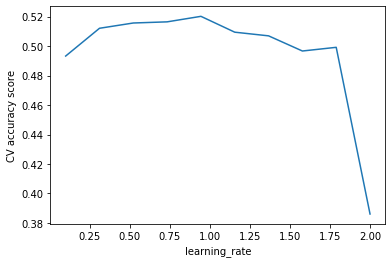

In [308]:
plt.plot(ada_lr[:, 0], ada_lr[:, 1])
plt.xlabel('learning_rate')
plt.ylabel('CV accuracy score')
# plt.xticks(ada_lr[:, 0])
plt.savefig('ad-lr.png')

In [298]:
ada_fav = AdaBoostClassifier(random_state=42, n_estimators=50, learning_rate=0.9)
cv_acc(ada_fav)

LOG: Shape of train: (5637, 169), (5637,)
LOG: Shape of dev: (1410, 169), (5637,)
LOG: Shape of test: (784, 169), (784,)
LOG: Model AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.9,
                   n_estimators=50, random_state=42)
LOG: Calculating accuracy on the test data...
LOG: Accuracy on the test data is 0.53418470643202
LOG: Cross val score: 0.5195533407921994
LOG: Mean elapsed for each cv: 0.7627906799316406



0.5195533407921994

## GradientBoosting

In [96]:
gradb_base = GradientBoostingClassifier()
cv_acc(gradb_base)

LOG: Shape of train: (5637, 169), (5637,)
LOG: Shape of dev: (1410, 169), (5637,)
LOG: Shape of test: (784, 169), (784,)
LOG: Model GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
LOG: Cross val score: 0.5237531349662836

LOG: Mean elapsed for each cv: 5.469674110412598


In [299]:
gb_lr = [(val, 
             cv_acc(GradientBoostingClassifier(learning_rate=val)))
            for val in np.linspace(0.1, 2, 10)]
gb_lr = np.array(gb_lr)
gb_lr

LOG: Shape of train: (5637, 169), (5637,)
LOG: Shape of dev: (1410, 169), (5637,)
LOG: Shape of test: (784, 169), (784,)
LOG: Model GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
LOG: Calculating accuracy on the test data...
LOG: Accuracy on the test data is 0.5995950786481856
LOG: Cross val score: 0.526556876682639
LOG: Mean elapsed for each cv: 5.483799695968628

LOG

LOG: Accuracy on the test data is 0.48948761875097335
LOG: Cross val score: 0.38963209526661
LOG: Mean elapsed for each cv: 5.601920223236084

LOG: Shape of train: (5637, 169), (5637,)
LOG: Shape of dev: (1410, 169), (5637,)
LOG: Shape of test: (784, 169), (784,)
LOG: Model GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=2.0, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
LOG: Calculating accuracy on the test data...
LOG

array([[0.1       , 0.52655688],
       [0.31111111, 0.51690367],
       [0.52222222, 0.51425181],
       [0.73333333, 0.50615272],
       [0.94444444, 0.49524697],
       [1.15555556, 0.4812359 ],
       [1.36666667, 0.48310833],
       [1.57777778, 0.4770212 ],
       [1.78888889, 0.3896321 ],
       [2.        , 0.35555663]])

In [300]:
gb_lr2 = [(val, 
             cv_acc(GradientBoostingClassifier(learning_rate=val)))
            for val in np.linspace(0.01, 0.1, 10)]
gb_lr2 = np.array(gb_lr2)
gb_lr2

LOG: Shape of train: (5637, 169), (5637,)
LOG: Shape of dev: (1410, 169), (5637,)
LOG: Shape of test: (784, 169), (784,)
LOG: Model GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.01, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
LOG: Calculating accuracy on the test data...
LOG: Accuracy on the test data is 0.5109795981934279
LOG: Cross val score: 0.4969649768657973
LOG: Mean elapsed for each cv: 5.331146574020385

L

LOG: Accuracy on the test data is 0.5941442142968385
LOG: Cross val score: 0.5265605131829196
LOG: Mean elapsed for each cv: 5.831465196609497

LOG: Shape of train: (5637, 169), (5637,)
LOG: Shape of dev: (1410, 169), (5637,)
LOG: Shape of test: (784, 169), (784,)
LOG: Model GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
LOG: Calculating accuracy on the test data...
LO

array([[0.01      , 0.49696498],
       [0.02      , 0.5067788 ],
       [0.03      , 0.51332086],
       [0.04      , 0.52001809],
       [0.05      , 0.52157548],
       [0.06      , 0.52515937],
       [0.07      , 0.52765134],
       [0.08      , 0.52702599],
       [0.09      , 0.52656051],
       [0.1       , 0.52671422]])

In [302]:
gb_lr_full = np.concatenate((gb_lr2, gb_lr))
gb_lr_full

array([[0.01      , 0.49696498],
       [0.02      , 0.5067788 ],
       [0.03      , 0.51332086],
       [0.04      , 0.52001809],
       [0.05      , 0.52157548],
       [0.06      , 0.52515937],
       [0.07      , 0.52765134],
       [0.08      , 0.52702599],
       [0.09      , 0.52656051],
       [0.1       , 0.52671422],
       [0.1       , 0.52655688],
       [0.31111111, 0.51690367],
       [0.52222222, 0.51425181],
       [0.73333333, 0.50615272],
       [0.94444444, 0.49524697],
       [1.15555556, 0.4812359 ],
       [1.36666667, 0.48310833],
       [1.57777778, 0.4770212 ],
       [1.78888889, 0.3896321 ],
       [2.        , 0.35555663]])

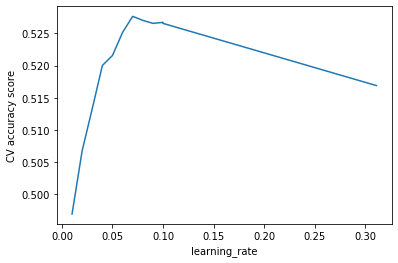

In [309]:
to_plot = gb_lr_full[:12]

plt.plot(to_plot[:, 0], to_plot[:, 1])
plt.xlabel('learning_rate')
plt.ylabel('CV accuracy score')
# plt.xticks(to_plot[:, 0])
plt.savefig('gb-lr.png')

In [318]:
gb_fav = GradientBoostingClassifier(learning_rate=0.07)
cv_acc(gb_fav)

LOG: Shape of train: (5637, 169), (5637,)
LOG: Shape of dev: (1410, 169), (5637,)
LOG: Shape of test: (784, 169), (784,)
LOG: Model GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.07, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
LOG: Calculating accuracy on the test data...
LOG: Accuracy on the test data is 0.5815293567980065
LOG: Cross val score: 0.525779271705967
LOG: Mean elapsed for each cv: 5.430835437774658



0.525779271705967

## Random

In [101]:
knbr_base = KNeighborsClassifier()
cv_acc(knbr_base)

LOG: Shape of train: (5637, 169), (5637,)
LOG: Shape of dev: (1410, 169), (5637,)
LOG: Shape of test: (784, 169), (784,)
LOG: Model KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')
LOG: Cross val score: 0.4370144817562841

LOG: Mean elapsed for each cv: 1.8306029796600343


## Voting classifier

In [87]:
vote3_base = VotingClassifier(estimators=[
    ('logreg_base', logreg_base),
    ('sgd_default', sgd_default),
    ('rf_base', rf_base)
], voting='hard')

cv_acc(vote3_base)

LOG: Shape of train: (5637, 169), (5637,)
LOG: Shape of dev: (1410, 169), (5637,)
LOG: Shape of test: (784, 169), (784,)
LOG: Model VotingClassifier(estimators=[('logreg_base',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('sgd_default',
                              SGDClassifier(alpha=0.0001, average=False,
                               

/home/simeon/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/simeon/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/simeon/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/simeon/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/simeon/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWa

LOG: Cross val score: 0.4915246512293189

LOG: Mean elapsed for each cv: 1.020997905731201


/home/simeon/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [86]:
vote3_svm = VotingClassifier(estimators=[
    ('logreg_base', logreg_base),
    ('svm_probs', svm_probs),
    ('rf_base', rf_base)
], voting='soft')

cv_acc(svm_probs)

LOG: Shape of train: (5637, 169), (5637,)
LOG: Shape of dev: (1410, 169), (5637,)
LOG: Shape of test: (784, 169), (784,)
LOG: Model SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=True, random_state=42,
    shrinking=True, tol=0.001, verbose=False)


/home/simeon/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/simeon/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/simeon/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/simeon/anaconda3/lib/python3.7/site-packages/skle

LOG: Cross val score: 0.5088042096127248

LOG: Mean elapsed for each cv: 34.6912603855133


In [77]:
vote2_base = VotingClassifier(estimators=[
    ('logreg_base', logreg_base),
    ('rf_base', rf_base)
], voting='soft')

cv_acc(vote2_base)

LOG: Shape of train: (5637, 169), (5637,)
LOG: Shape of dev: (1410, 169), (5637,)
LOG: Shape of test: (784, 169), (784,)
LOG: Model VotingClassifier(estimators=[('logreg_base',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('rf_base',
                              ExtraTreesClassifier(bootstrap=False,
                                        

/home/simeon/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/simeon/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/simeon/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/simeon/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/simeon/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWa

LOG: Cross val score: 0.5186202148201933

LOG: Mean elapsed for each cv: 0.44447999000549315


/home/simeon/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/simeon/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [97]:
vote2_boosts = VotingClassifier(estimators=[
    ('ada_base', ada_base),
    ('gradb_base', gradb_base)
], voting='soft')

cv_acc(vote2_boosts)

LOG: Shape of train: (5637, 169), (5637,)
LOG: Shape of dev: (1410, 169), (5637,)
LOG: Shape of test: (784, 169), (784,)
LOG: Model VotingClassifier(estimators=[('ada_base',
                              AdaBoostClassifier(algorithm='SAMME.R',
                                                 base_estimator=None,
                                                 learning_rate=1.0,
                                                 n_estimators=50,
                                                 random_state=None)),
                             ('gradb_base',
                              GradientBoostingClassifier(criterion='friedman_mse',
                                                         init=None,
                                                         learning_rate=0.1,
                                                         loss='deviance',
                                                         max_depth=3,
                                                         max_featur

In [99]:
vote_everything = VotingClassifier(estimators=[
    ('ada_base', ada_base),
    ('gradb_base', gradb_base),
    ('logreg_base', logreg_base),
    ('rf_base', rf_base),
    ('svm_probs', svm_probs)
], voting='soft')

cv_acc(vote_everything)

LOG: Shape of train: (5637, 169), (5637,)
LOG: Shape of dev: (1410, 169), (5637,)
LOG: Shape of test: (784, 169), (784,)
LOG: Model VotingClassifier(estimators=[('ada_base',
                              AdaBoostClassifier(algorithm='SAMME.R',
                                                 base_estimator=None,
                                                 learning_rate=1.0,
                                                 n_estimators=50,
                                                 random_state=None)),
                             ('gradb_base',
                              GradientBoostingClassifier(criterion='friedman_mse',
                                                         init=None,
                                                         learning_rate=0.1,
                                                         loss='deviance',
                                                         max_depth=3,
                                                         max_featur

/home/simeon/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/simeon/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/simeon/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/simeon/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this

LOG: Cross val score: 0.5257807263060794

LOG: Mean elapsed for each cv: 41.836613750457765


In [103]:
play = VotingClassifier(estimators=[
    ('ada_base', ada_base),
    ('gradb_base', gradb_base),
    ('logreg_base', logreg_base)
], voting='soft')

cv_acc(play)

LOG: Shape of train: (5637, 169), (5637,)
LOG: Shape of dev: (1410, 169), (5637,)
LOG: Shape of test: (784, 169), (784,)
LOG: Model VotingClassifier(estimators=[('ada_base',
                              AdaBoostClassifier(algorithm='SAMME.R',
                                                 base_estimator=None,
                                                 learning_rate=1.0,
                                                 n_estimators=50,
                                                 random_state=None)),
                             ('gradb_base',
                              GradientBoostingClassifier(criterion='friedman_mse',
                                                         init=None,
                                                         learning_rate=0.1,
                                                         loss='deviance',
                                                         max_depth=3,
                                                         max_featur

/home/simeon/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/simeon/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/simeon/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/simeon/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


LOG: Cross val score: 0.5254707752654948

LOG: Mean elapsed for each cv: 6.364017391204834


/home/simeon/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [320]:
fav = VotingClassifier(estimators=[
    ('rf_fav', rf_fav),
    ('gb_fav', gb_fav),
    ('logreg_fav', logreg_fav)
], voting='soft')

cv_acc(fav)

LOG: Shape of train: (5637, 169), (5637,)
LOG: Shape of dev: (1410, 169), (5637,)
LOG: Shape of test: (784, 169), (784,)
LOG: Model VotingClassifier(estimators=[('rf_fav',
                              RandomForestClassifier(bootstrap=True,
                                                     class_weight=None,
                                                     criterion='gini',
                                                     max_depth=None,
                                                     max_features='auto',
                                                     max_leaf_nodes=300,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0,
            

/home/simeon/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LOG: Accuracy on the test data is 0.6382183460520168


/home/simeon/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/simeon/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/simeon/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/simeon/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LOG: Cross val score: 0.5309241923029835
LOG: Mean elapsed for each cv: 9.10118465423584



/home/simeon/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.5309241923029835